# medication

The medications table reflects the active medication orders for patients. These are orders but do not necessarily reflect administration to the patient. For example, while existence of data in the infusionDrug table confirms a patient received a continuous infusion, existence of the same data in this table only indicates that the infusion was *ordered* for the patient. Most orders are fulfilled, but not all. Furthermore, many orders are done *pro re nata*, or PRN, which means "when needed". Administration of these orders is difficult to quantify.

In the US, all orders must be reviewed by a pharmacist. The majority of hospitals have an HL7 medication interface system in place which automatically synchronizes the orders with eCareManager (the source of this database) as they are verified by the pharmacist in the source pharmacy system. For hospitals without a medication interface, the eICU staff may enter a selection of medications to facilitate population management and completeness for reporting purposes.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [8]:
patientunitstayid = 237395

In [10]:
query = query_schema + """
select *
from medication
where patientunitstayid = {}
order by drugorderoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,medicationid,patientunitstayid,drugorderyear,drugordertime24,drugordertime,drugorderoffset,drugstartyear,drugstarttime24,drugstarttime,drugstartoffset,...,drughiclseqno,dosage,routeadmin,loadingdose,prn,drugstopyear,drugstoptime24,drugstoptime,drugstopoffset,gtc
0,7461175,237395,2015,22:56:26,midnight,-12,2015,21:37:00,night,-91,...,10093.0,"1,500 3",IV,,No,2015,21:36:54,night,-92,19
1,10812193,237395,2015,22:56:26,midnight,-12,2015,21:23:00,night,-105,...,4053.0,2000 MG,IV,,No,2015,23:45:00,midnight,37,19
2,11612134,237395,2015,22:56:26,midnight,-12,2015,22:07:00,midnight,-61,...,4034.0,420 MG,IV,,No,2015,03:15:00,morning,247,19
3,11206166,237395,2015,22:56:26,midnight,-12,2015,21:23:00,night,-105,...,10093.0,"1,500 3",IV,,No,2015,02:06:00,morning,178,19
4,8246015,237395,2015,23:38:17,midnight,30,2015,05:00:00,morning,352,...,4053.0,2000 MG,IV,,No,2015,15:45:32,evening,3877,19


In [11]:
df.columns

Index(['medicationid', 'patientunitstayid', 'drugorderyear', 'drugordertime24',
       'drugordertime', 'drugorderoffset', 'drugstartyear', 'drugstarttime24',
       'drugstarttime', 'drugstartoffset', 'drugivadmixture',
       'drugordercancelled', 'drugname', 'drughiclseqno', 'dosage',
       'routeadmin', 'loadingdose', 'prn', 'drugstopyear', 'drugstoptime24',
       'drugstoptime', 'drugstopoffset', 'gtc'],
      dtype='object')

In [14]:
# Look at a subset of columns
cols = ['medicationid','patientunitstayid',
        'drugorderoffset','drugorderoffset', 'drugstopoffset',
        'drugivadmixture', 'drugordercancelled', 'drugname','drughiclseqno', 'gtc',
       'dosage','routeadmin','loadingdose', 'prn']
df[cols].head().T

,0,1,2,3,4
medicationid,7461175,10812193,11612134,11206166,8246015
patientunitstayid,237395,237395,237395,237395,237395
drugorderoffset,-12,-12,-12,-12,30
drugorderoffset,-12,-12,-12,-12,30
drugstopoffset,-92,37,247,178,3877
drugivadmixture,No,Yes,Yes,No,Yes
drugordercancelled,No,No,No,No,No
drugname,VANCOMYCIN 1.5 GM IN NS 250 ML IVPB (REPACKAGE),AZTREONAM 2 G IJ SOLR,TOBRAMYCIN SULFATE 80 MG/2ML IJ SOLN,VANCOMYCIN 1.5 GM IN NS 250 ML IVPB (REPACKAGE),AZTREONAM 2 G IJ SOLR
drughiclseqno,10093,4053,4034,10093,4053
gtc,19,19,19,19,19


Here we can see that, roughly on ICU admission, the patient had an order for vancomycin, aztreonam, and tobramycin.

## Identifying patients admitted on a single drug

Let's look for patients who have an order for vancomycin using exact text matching.

In [15]:
drug = 'VANCOMYCIN'
query = query_schema + """
select 
  distinct patientunitstayid
from medication
where drugname like '%{}%'
""".format(drug)

df_drug = pd.read_sql_query(query, con)
print('{} unit stays with {}.'.format(df_drug.shape[0], drug))

29737 unit stays with VANCOMYCIN.


Exact text matching is fairly weak, as there's no systematic reason to prefer upper case or lower case. Let's relax the case matching.

In [16]:
drug = 'VANCOMYCIN'
query = query_schema + """
select 
  distinct patientunitstayid
from medication
where drugname ilike '%{}%'
""".format(drug)

df_drug = pd.read_sql_query(query, con)
print('{} unit stays with {}.'.format(df_drug.shape[0], drug))

41867 unit stays with VANCOMYCIN.


HICL codes are used to group together drugs which have the same underlying ingredient (i.e. most frequently this is used to group brand name drugs with the generic name drugs). We can see above the HICL for vancomycin is 10093, so let's try grabbing that.

In [17]:
hicl = 10093
query = query_schema + """
select 
  distinct patientunitstayid
from medication
where drughiclseqno = {}
""".format(hicl)

df_hicl = pd.read_sql_query(query, con)
print('{} unit stays with HICL = {}.'.format(df_hicl.shape[0], hicl))

9716 unit stays with HICL = 10093.


No luck! I wonder what we missed? Let's go back to the original query, this time retaining HICL and the name of the drug.

In [18]:
drug = 'VANCOMYCIN'
query = query_schema + """
select 
  drugname, drughiclseqno, count(*) as n
from medication
where drugname ilike '%{}%'
group by drugname, drughiclseqno
order by n desc
""".format(drug)

df_drug = pd.read_sql_query(query, con)
df_drug.head()

,drugname,drughiclseqno,n
0,VANCOMYCIN HCL 1000 MG IV SOLR,4042.0,9661
1,vancomycin,4042.0,7826
2,VANCOmycin 1 GM in NS 250 mL IVPB,10093.0,3977
3,VANCOMYCIN HCL 10 G IV SOLR,4042.0,3891
4,VANCOMYCIN HCL,4042.0,3064


It appears there are more than one HICL - we can group by HICL in this query to get an idea.

In [19]:
df_drug['drughiclseqno'].value_counts()

4042.0     333
10093.0    206
37442.0    119
8466.0      53
920.0       15
24859.0      8
3976.0       7
1694.0       3
4285.0       3
4283.0       3
8259.0       3
18084.0      2
6312.0       2
1403.0       1
Name: drughiclseqno, dtype: int64

Unfortunately, we can't be sure that these HICLs always identify only vancomycin. For example, let's look at drugnames for HICL = 1403.

In [20]:
hicl = 1403
query = query_schema + """
select 
  drugname, count(*) as n
from medication
where drughiclseqno = {}
group by drugname
order by n desc
""".format(hicl)

df_hicl = pd.read_sql_query(query, con)
df_hicl.head()

,drugname,n
0,compounded cream,9
1,Rx compound and Mix,8
2,butt butter compound,7
3,TESTOSTERONE 1 % (25 MG/2.5 G) TD GLPK,7
4,zinc/aquaphor/nystatin,5


This HICL seems more focused on the use of creams than on vancomycin. Let's instead inspect the top 3.

In [21]:
for hicl in [4042, 10093, 37442]:
    query = query_schema + """
    select 
      drugname, count(*) as n
    from medication
    where drughiclseqno = {}
    group by drugname
    order by n desc
    """.format(hicl)

    df_hicl = pd.read_sql_query(query, con)
    print('HICL {}'.format(hicl))
    print('Number of rows: {}'.format(df_hicl['n'].sum()))
    print('Top 5 rows by frequency:')
    print(df_hicl.head())
    print()

HICL 4042
Number of rows: 68951
Top 5 rows by frequency:
                         drugname     n
0  VANCOMYCIN HCL 1000 MG IV SOLR  9661
1                      vancomycin  7826
2                        VANCOCIN  4613
3     VANCOMYCIN HCL 10 G IV SOLR  3891
4                  VANCOMYCIN HCL  3064

HICL 10093
Number of rows: 18553
Top 5 rows by frequency:
                                           drugname     n
0                 VANCOmycin 1 GM in NS 250 mL IVPB  3977
1  VANCOMYCIN 1.25 GM IN NS 250 ML IVPB (REPACKAGE)  2037
2               VANCOmycin 1.25 GM in NS 500ML IVPB  1970
3                VANCOmycin 1.5 GM in NS 500ML IVPB  1944
4   VANCOMYCIN 1.5 GM IN NS 250 ML IVPB (REPACKAGE)  1475

HICL 37442
Number of rows: 3977
Top 5 rows by frequency:
                                          drugname     n
0         VANCOMYCIN 1 G MINI-BAG PLUS (VIAL MATE)  1856
1  VANCOMYCIN HCL IN DEXTROSE 750 MG/150ML IV SOLN   822
2                        VANCOMYCIN 5gm VIAL (MDV)   525
3         

This is fairly convincing that these only refer to vancomycin. An alternative approach is to acquire the code book for HICL codes and look up vancomycin there.

## Hospitals with data available

In [22]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from medication
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6836,96.840912
54,167,6092,5825,95.617203
106,264,5237,5111,97.594042
184,420,4679,4618,98.696303
134,338,4277,4241,99.158289
58,176,4328,4186,96.719039
90,243,4243,4172,98.326656
71,199,4240,4116,97.075472
206,458,3701,3624,97.919481
200,443,3656,3612,98.796499


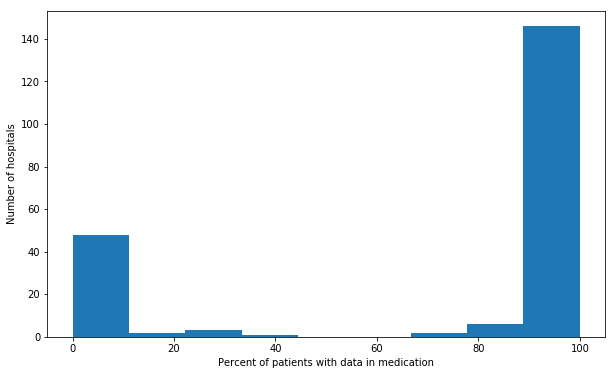

In [23]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in medication')
plt.ylabel('Number of hospitals')
plt.show()

Here we can see there are a few hospitals with no interface, and thus 0 patients, though the majority have >90% data completion.